## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [67]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [68]:
train_df = pd.read_csv('./data/train-balanced-sarcasm.csv')

In [69]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [70]:
def data_report(df):
    '''Esta funcion describe los campos de un dataframe de pandas de forma bastante clara, crack'''
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)


    return concatenado.T

In [71]:
data_report(train_df)

COL_N,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
DATA_TYPE,int64,object,object,object,int64,int64,int64,object,object,object
MISSINGS (%),0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,2,962294,256561,14878,1291,1171,2,96,1004689,984286
CARDIN (%),0.0,95.2,25.38,1.47,0.13,0.12,0.0,0.01,99.39,97.37


Some comments are missing, so we drop the corresponding rows.

In [72]:
train_df.dropna(inplace=True)

In [73]:
train_df['comments'] = train_df['comment'].str.replace('[^\w\s]','') 

#train_df.drop(['comment'],inplace=True, axis=1)

C:\Users\glezr\AppData\Local\Temp\ipykernel_19252\252017548.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



train_df = train_df[['label',
 'comments',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']]

In [74]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comments
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",NC and NH
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,They were underdogs earlier today but since Gr...
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,This meme isnt funny none of the new york nigg...
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,I could use one of those tools


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
 10  comments        1010773 non-null  object
dtypes: int64(4), object(7)
memory usage: 92.5+ MB


We notice that the dataset is indeed balanced

In [76]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [77]:
data_report(train_df)

COL_N,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comments
DATA_TYPE,int64,object,object,object,int64,int64,int64,object,object,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,2,962294,256560,14876,1291,1171,2,96,1004637,984238,946835
CARDIN (%),0.0,95.2,25.38,1.47,0.13,0.12,0.0,0.01,99.39,97.37,93.67


In [78]:
sin_nada = train_df.comments.apply(lambda x: len([len(w) for w in str(x).split()]) == 0)

In [79]:
data_report(train_df[sin_nada])

COL_N,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comments
DATA_TYPE,int64,object,object,object,int64,int64,int64,object,object,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,2,168,1026,485,47,46,2,69,1042,1017,4
CARDIN (%),0.19,16.12,98.46,46.55,4.51,4.41,0.19,6.62,100.0,97.6,0.38


In [80]:
train_df[sin_nada].comment.value_counts()

:(               193
:)               125
?                106
...               75
;)                68
                ... 
.....?             1
..........         1
.............      1
[- .. -- .]        1
(\^;               1
Name: comment, Length: 168, dtype: int64

We split data into training and validation parts.

In [81]:
train_df.drop(['comment'],inplace=True, axis=1)

In [82]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comments'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

In [83]:
import plotly.graph_objs as go
import plotly.offline as py

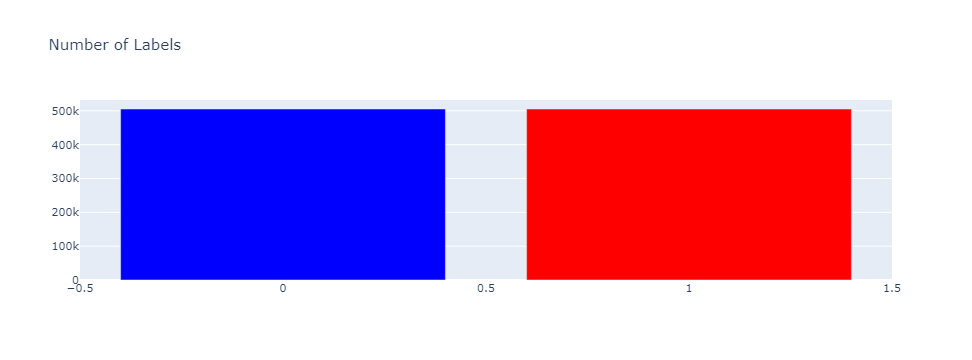

In [84]:
cnt_lbl = train_df['label'].value_counts()
trace = go.Bar(
    x=cnt_lbl.index,
    y=cnt_lbl.values,
    marker=dict(
        color=cnt_lbl.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of Labels',
    font=dict(size=11)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

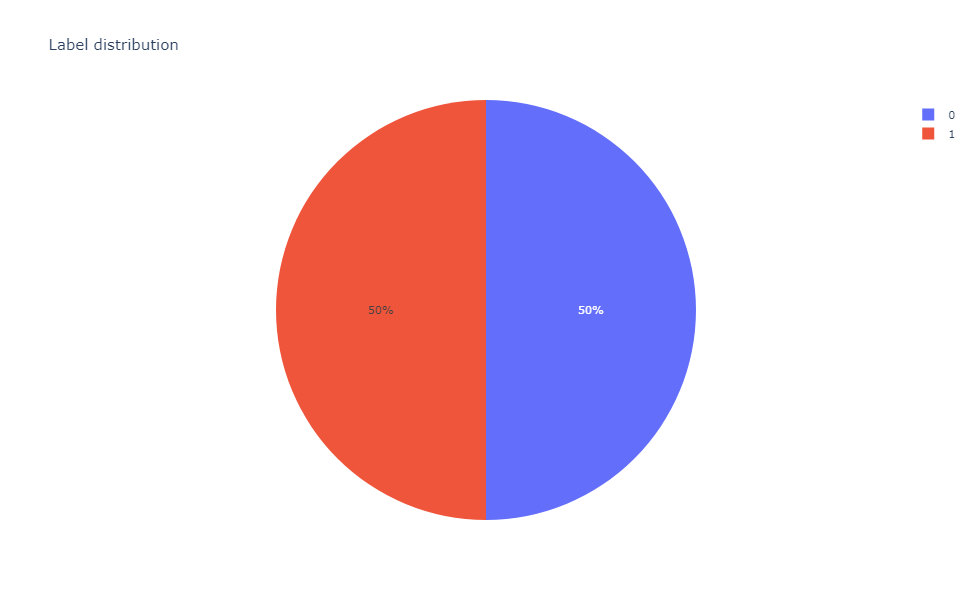

In [85]:
labels = (np.array(cnt_lbl.index))
sizes = (np.array((cnt_lbl / cnt_lbl.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Label distribution',
    font=dict(size=11),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

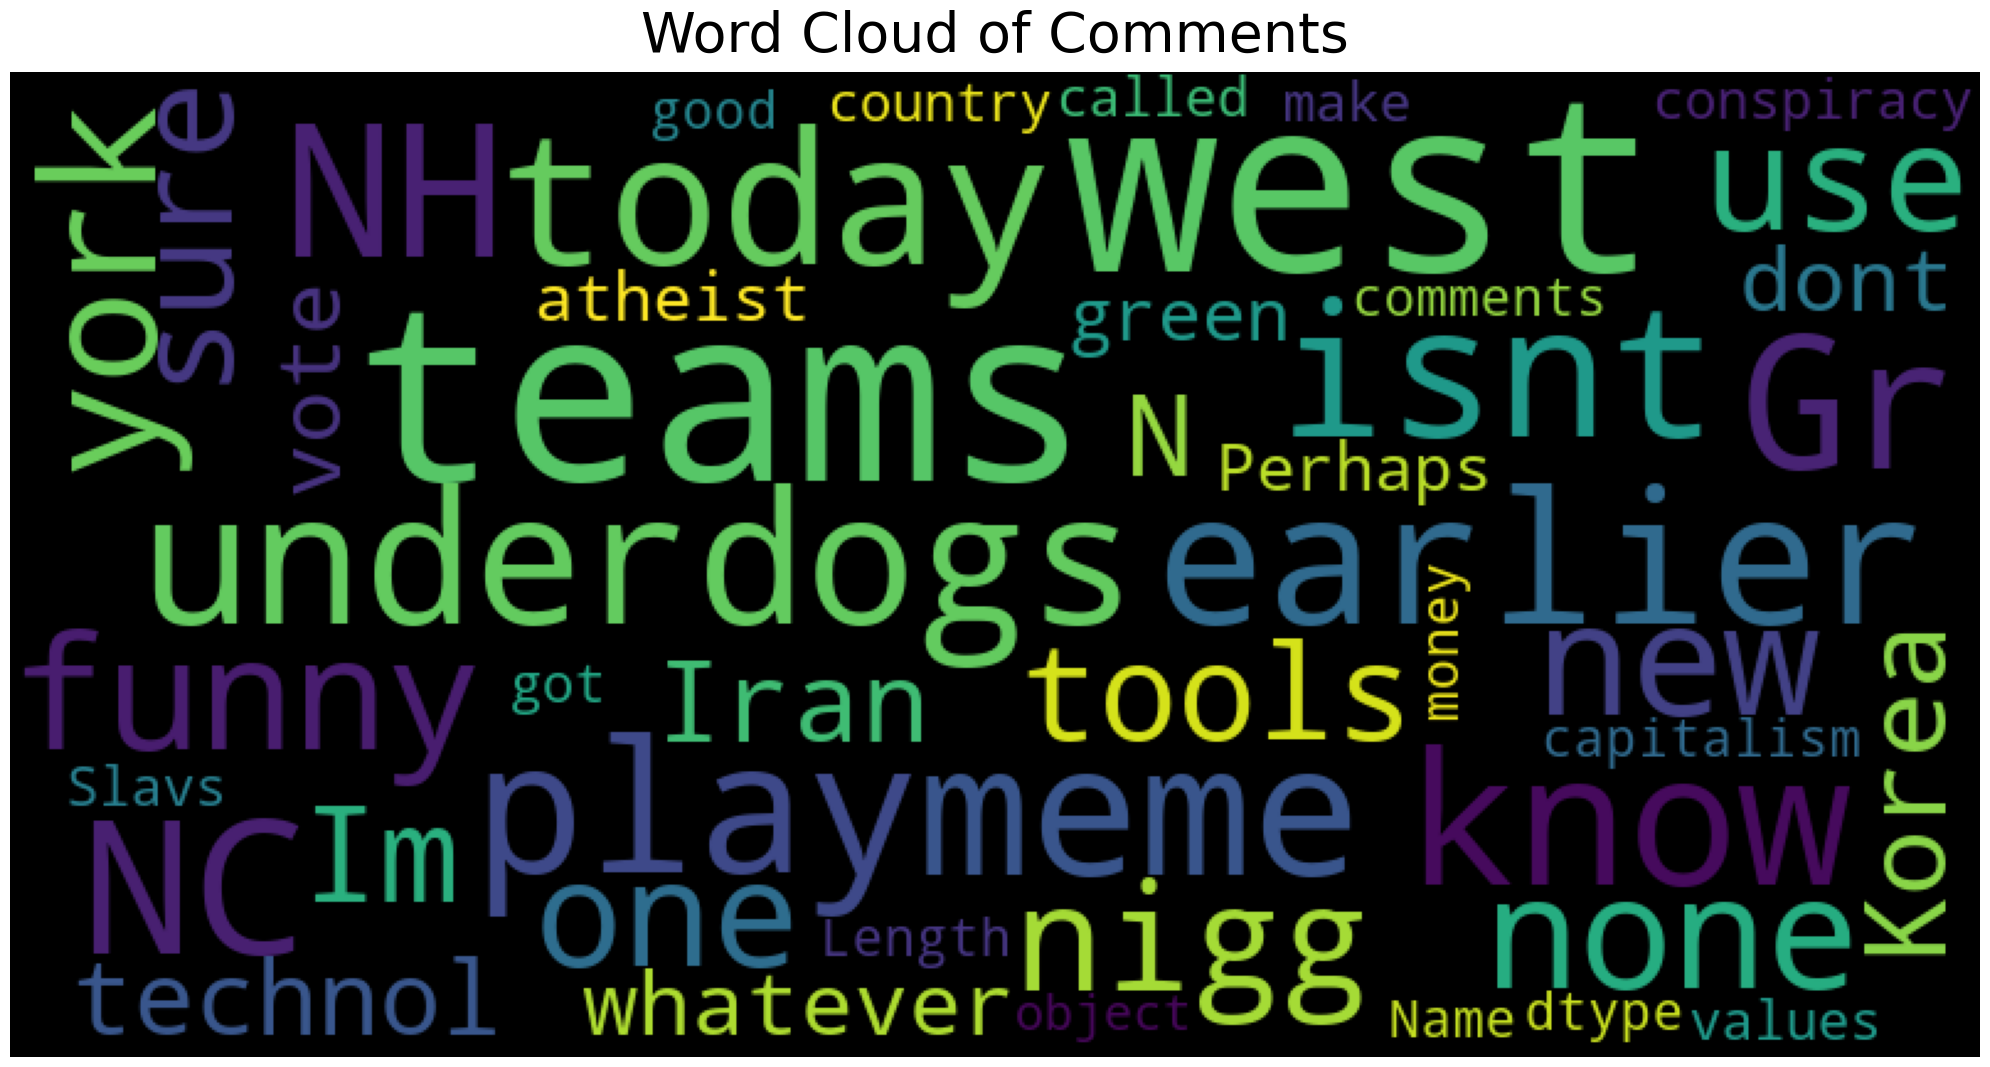

In [86]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(20.0,12.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["comments"], title="Word Cloud of Comments")

C:\Users\glezr\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



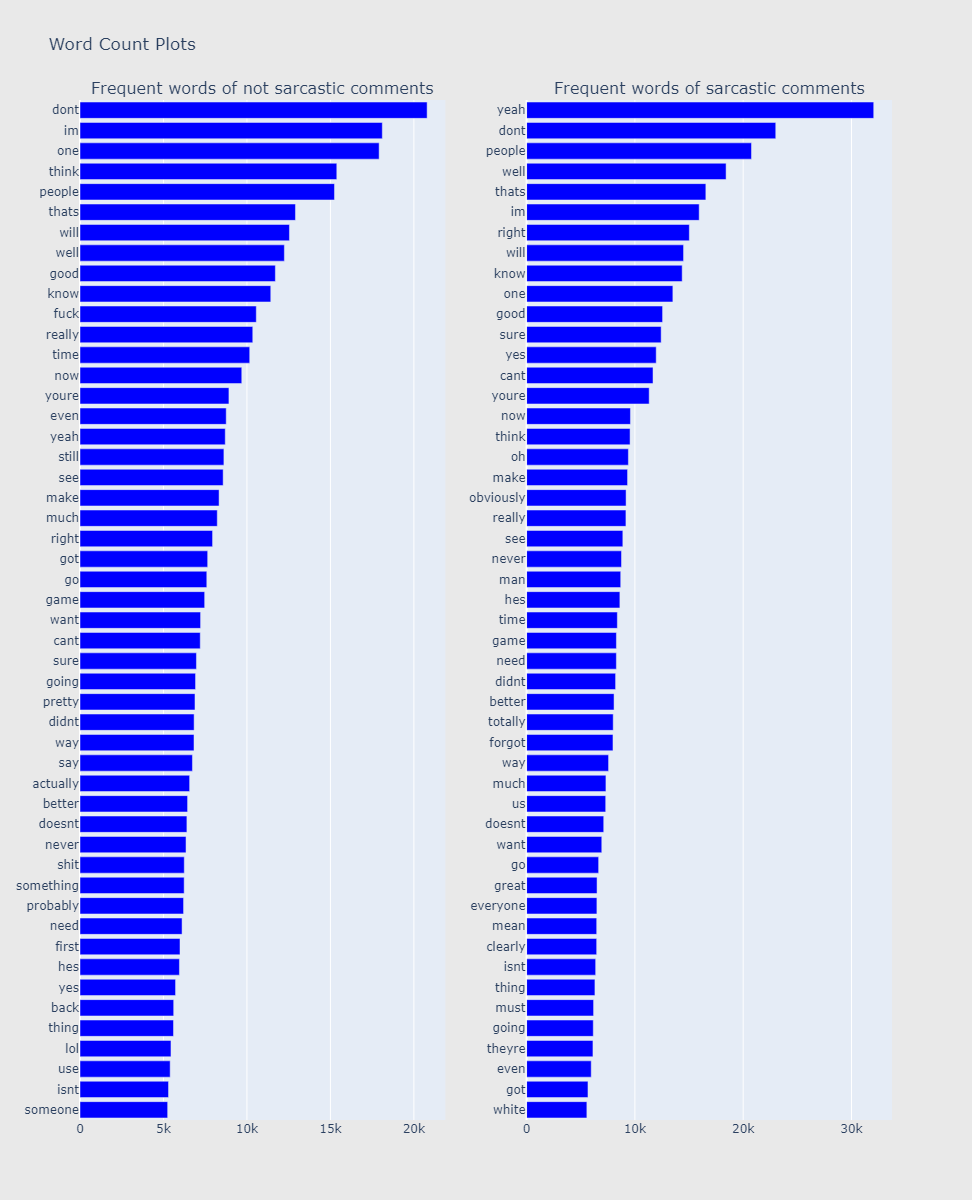

In [87]:
from collections import defaultdict
from plotly import tools

train1_df = train_df[train_df["label"]==1]
train0_df = train_df[train_df["label"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from not sarcastic comment ##
freq_dict = defaultdict(int)
for sent in train0_df["comments"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from sarcastic comment ##
freq_dict = defaultdict(int)
for sent in train1_df["comments"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of not sarcastic comments", 
                                          "Frequent words of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\glezr\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



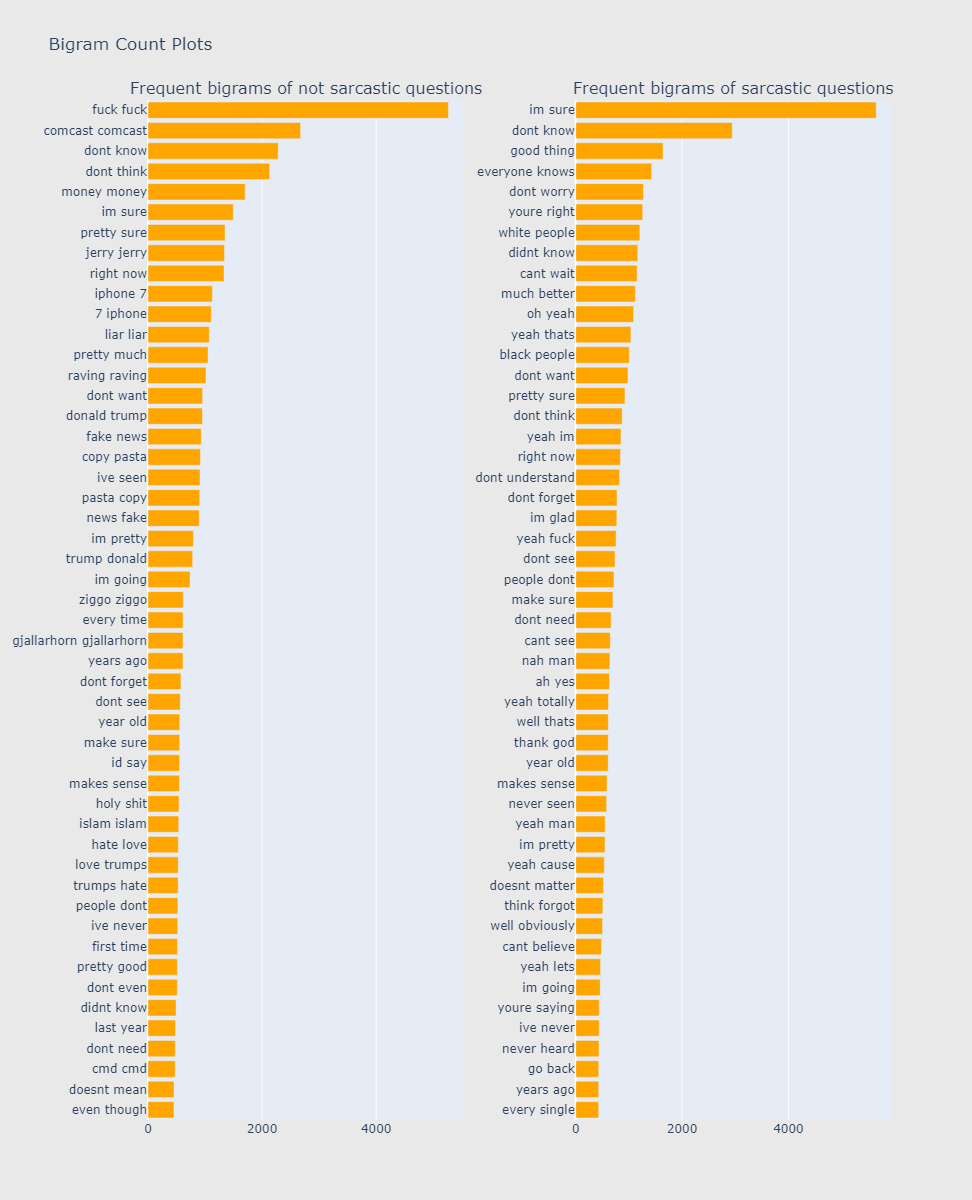

In [88]:
freq_dict = defaultdict(int)
for sent in train0_df["comments"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["comments"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of not sarcastic questions", 
                                          "Frequent bigrams of sarcastic questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\glezr\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



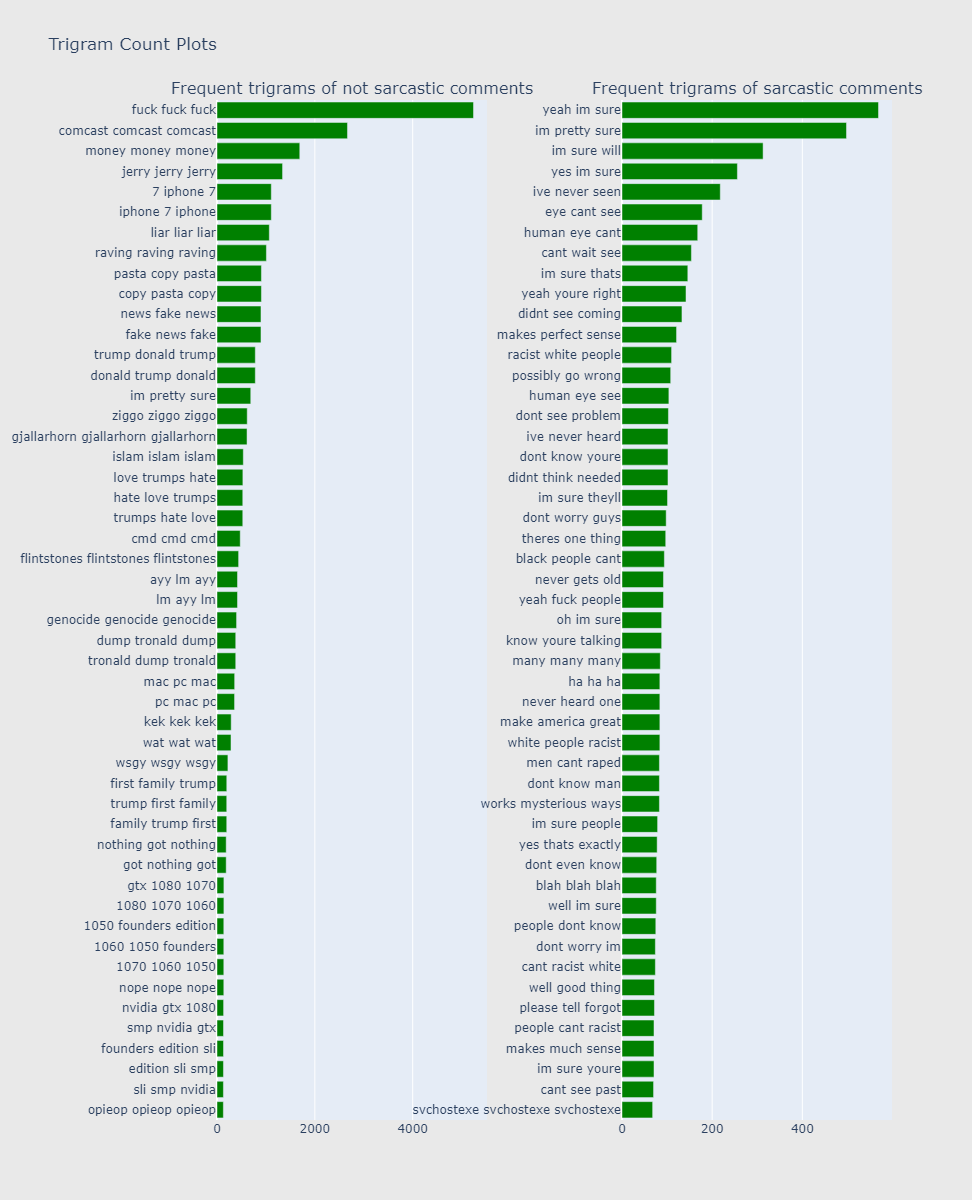

In [89]:
freq_dict = defaultdict(int)
for sent in train0_df["comments"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["comments"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of not sarcastic comments", 
                                          "Frequent trigrams of sarcastic comments"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

In [90]:
def most_frequent(output): 
    return max(set(output), key = output.count) 
  
print(most_frequent("Esto es una prueba de una prueba de un tipo de prueba que no sabemos si esta bien, prueba".split()))

prueba


In [91]:
from collections import Counter
from nltk import ngrams

#s = train0_df['comments'].to_json()
s = "Hola como estas esta noche. Bien, esta noche estoy bien y tu, como estas esta noche en el este. En el este la vida es esta noche"
ngram_counts = Counter(ngrams(s.split(), 2))
print(ngram_counts.most_common(10))

[(('esta', 'noche'), 3), (('como', 'estas'), 2), (('estas', 'esta'), 2), (('Hola', 'como'), 1), (('esta', 'noche.'), 1), (('noche.', 'Bien,'), 1), (('Bien,', 'esta'), 1), (('noche', 'estoy'), 1), (('estoy', 'bien'), 1), (('bien', 'y'), 1)]


In [92]:
import string

## Number of words in the text ##
train_df["num_words"] = train_df["comments"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["comments"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["comments"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["comments"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["comments"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["comments"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["comments"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


C:\Users\glezr\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.



In [93]:
import seaborn as sns
color = sns.color_palette()

Text(0.5, 1.0, 'Number of characters in each class')

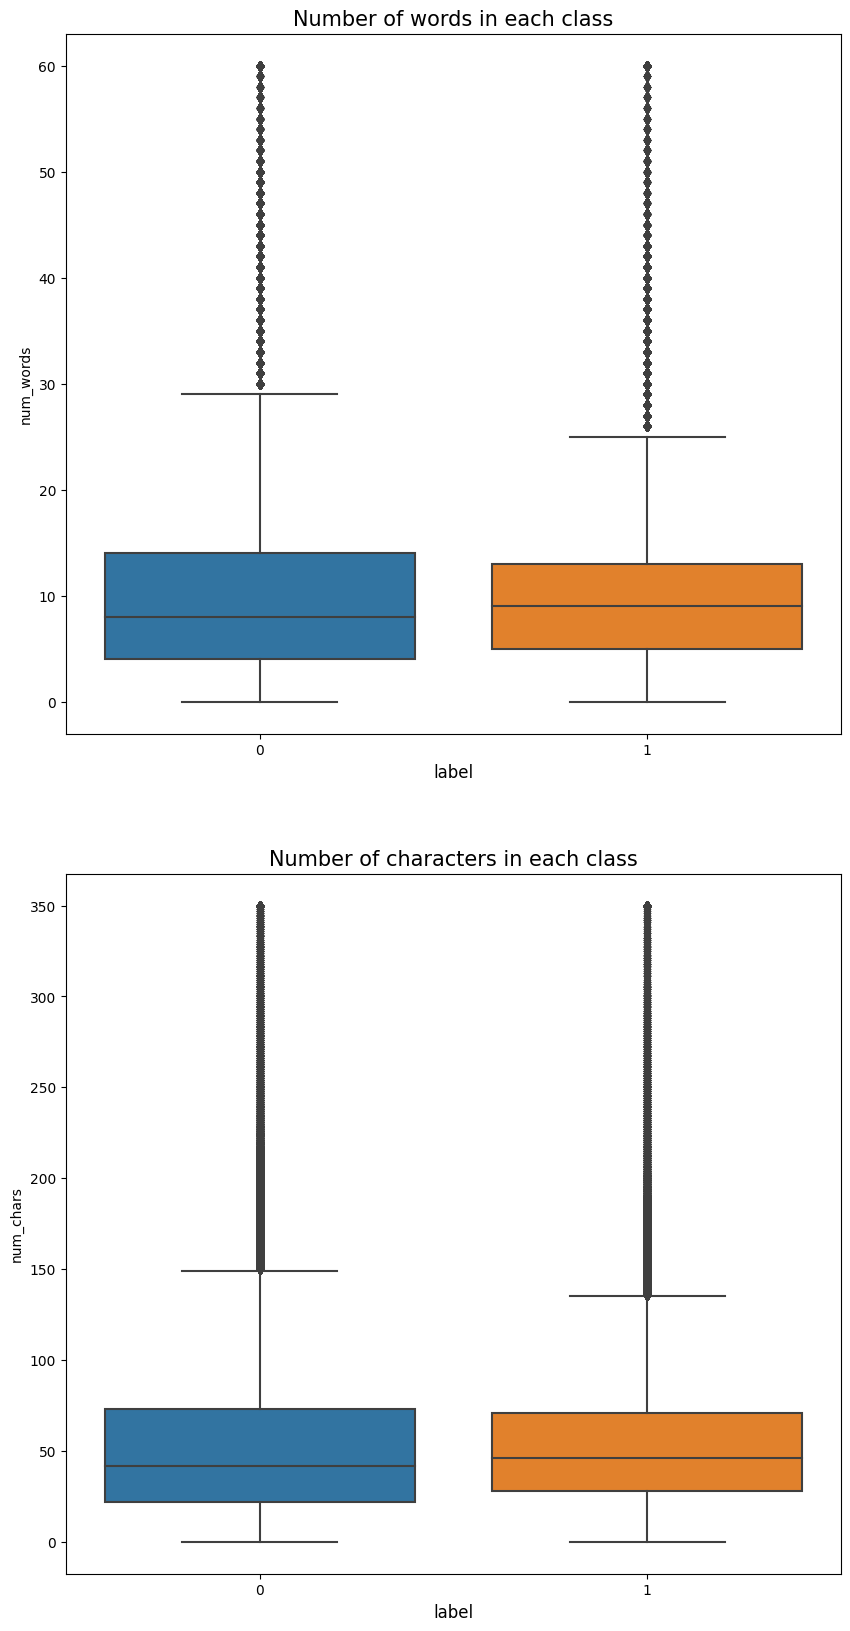

In [94]:
## Truncate some extreme values for better visuals ##
train_df.loc[train_df['num_words']>60, "num_words"] = 60 #truncation for better visuals
train_df.loc[train_df['num_chars']>350, "num_chars"] = 350 #truncation for better visuals

f, axes = plt.subplots(2, 1, figsize=(10,20))
sns.boxplot(x='label', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('label', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='label', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('label', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

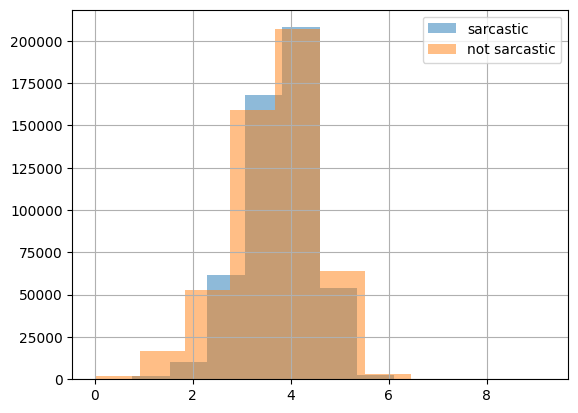

In [95]:
train_df.loc[train_df['label'] == 1, 'comments'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comments'].str.len().apply(np.log1p).hist(label='not sarcastic', alpha=.5)
plt.legend();

In [96]:
#Analizamos si en media hay subreddits más sarcasticas que otras

#Ordenados por total de comentarios

sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [97]:
#Ordenados de subreddits más sarcásticas a menos.

sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [98]:
# build bigrams, put a limit on maximal number of features and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [99]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    7.6s finished


CPU times: total: 25.9 s
Wall time: 34 s


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [100]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: total: 5.62 s
Wall time: 5.66 s


In [101]:
accuracy_score(y_valid, valid_pred)

0.7217464601454724

In [105]:
# Pintamos la matriz de confusión

def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

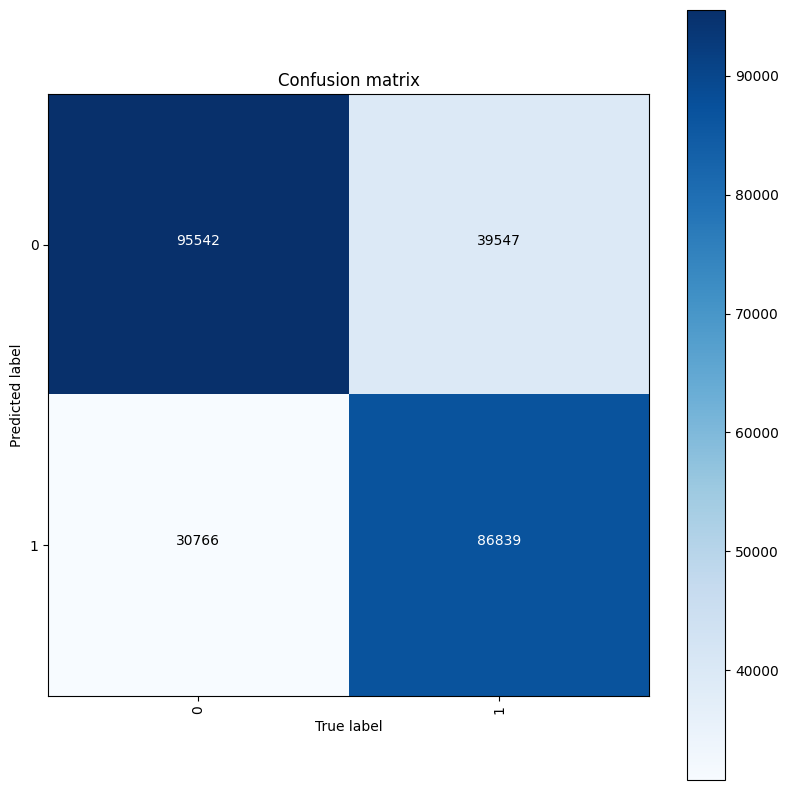

In [106]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay

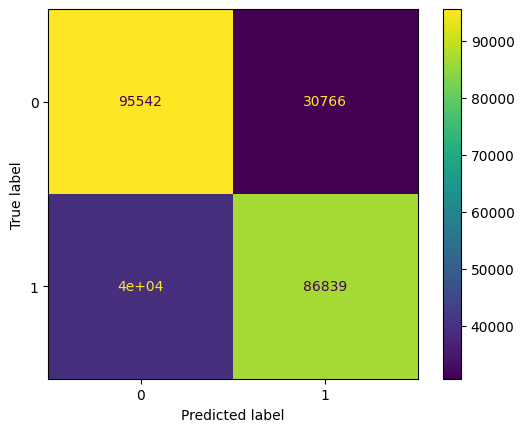

In [103]:
ConfusionMatrixDisplay.from_predictions(y_valid,valid_pred)

In [107]:
!pip install eli5

     ---------------------------------------- 0.0/216.2 kB ? eta -:--:--
     -------------------------------------- 216.2/216.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107768 sha256=396dd3b2f7ea5d6d6d07e1c7d575ddff54b18060c06ec4fc1ea17b6db112f09d
  Stored in directory: c:\users\glezr\appdata\local\pip\cache\wheels\b8\58\ef\2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [137]:
# Podemos observar los pesos de cada palabra para los comentarios sarcásticos

import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  feature_names = tfidf_logit_pipeline.named_steps['tf_idf'].get_feature_names_out())

Weight?,Feature
+8.700,yes because
+7.681,obviously
+7.615,clearly
+7.169,totally
+6.998,yeah because
+6.964,im sure
+6.095,because
+5.787,how dare
+5.514,right because
+5.213,good thing


Sin "eli5"

In [145]:
estimator=tfidf_logit_pipeline.named_steps['logit']

In [146]:
estimator.coef_

array([[-0.5579559 , -0.64890229,  0.76846374, ...,  0.1859159 ,
         0.07135226, -0.45306469]])

In [147]:
vec = tfidf_logit_pipeline.named_steps['tf_idf']

In [148]:
vec.get_feature_names_out()

array(['00', '000', '001', ..., 'zoom', 'zoom in', 'zoomed'], dtype=object)

In [149]:
words = vec.get_feature_names_out()

In [150]:
weights = estimator.coef_[0]

In [151]:
word_weights = list(zip(words, weights))

In [152]:
word_weights.sort( key = lambda x: x[1], reverse = True)

In [153]:
word_weights[0:10]

[('yes because', 8.70027457914732),
 ('obviously', 7.68139289565472),
 ('clearly', 7.614780471577476),
 ('totally', 7.1693703316432424),
 ('yeah because', 6.997967265334362),
 ('im sure', 6.964266895965967),
 ('because', 6.094976427207213),
 ('how dare', 5.787100409548206),
 ('right because', 5.514480634529888),
 ('good thing', 5.213202946572597)]

In [154]:
word_weights[-1:-11:-1]

[('true but', -4.57757728529409),
 ('fair enough', -4.387189317592149),
 ('iirc', -4.347260502964436),
 ('generally', -4.016852528928711),
 ('right but', -3.9796049050675495),
 ('it but', -3.929645338434313),
 ('that but', -3.88437046672004),
 ('necessarily', -3.8701021663564856),
 ('imo', -3.8053099327833655),
 ('not really', -3.698630831635384)]